<a href="https://colab.research.google.com/github/Eshaa2001/BrainAge/blob/main/Brain_Aging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# prompt: mount google drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install ace_tools
!pip install ace-tools # Install the missing library using pip. Note the hyphen instead of underscore.

In [ ]:
import os
import shutil
import random
import nibabel as nib
import numpy as np
from pathlib import Path

In [ ]:
# Mount your paths
drive_base = Path("/content/drive/MyDrive/Hippocampus/Hippocampus")
output_base = Path("/content/drive/MyDrive/nnUNet_raw_data/Task107_Hippocampus")

In [ ]:
# nnU-Net folders
imagesTr_dir = output_base / "imagesTr"
imagesTs_dir = output_base / "imagesTs"
labelsTr_dir = output_base / "labelsTr"

In [ ]:
# Create directories
imagesTr_dir.mkdir(parents=True, exist_ok=True)
imagesTs_dir.mkdir(parents=True, exist_ok=True)
labelsTr_dir.mkdir(parents=True, exist_ok=True)

In [ ]:
# Collect all subfolders
subfolders = [f for f in drive_base.iterdir() if f.is_dir()]
random.seed(42)
random.shuffle(subfolders)

In [ ]:
# Train/test split
split_idx = int(0.8 * len(subfolders))
train_folders = subfolders[:split_idx]
test_folders = subfolders[split_idx:]

In [ ]:
def extract_hippocampus(seg_path):
    seg_img = nib.load(str(seg_path))
    data = seg_img.get_fdata()
    affine = seg_img.affine

    # Round and cast to ensure integers only
    data = np.round(data).astype(int)
    print(data == 53)
    # Clean label map: 0=background, 1=left hippo (17), 2=right hippo (53)
    data_mapped = np.zeros_like(data, dtype=int)
    data_mapped[data == 17] = 1
    data_mapped[data == 53] = 2

    # Save without passing header (safer)
    return nib.Nifti1Image(data_mapped, affine)


In [ ]:
# Process training data
for folder in train_folders:
    nii_files = list(folder.glob("*.nii.gz"))
    image_file = next(f for f in nii_files if "seg" not in f.name.lower())
    label_file = next(f for f in nii_files if "seg" in f.name.lower())

    case_id = folder.name
    new_image_name = f"{case_id}_0000.nii.gz"
    new_label_name = f"{case_id}.nii.gz"

    # Copy image
    shutil.copy(image_file, imagesTr_dir / new_image_name)

    # --- Filter and remap labels (17 → 1, 53 → 2, else 0) ---
    seg_img = nib.load(label_file)
    seg_data = seg_img.get_fdata()
    seg_data = np.round(seg_data)  # Ensure proper rounding

    mapped = np.zeros_like(seg_data, dtype=np.uint8)
    mapped[seg_data == 17] = 1
    mapped[seg_data == 53] = 2

    new_label = nib.Nifti1Image(mapped, seg_img.affine)
    new_label.set_data_dtype(np.uint8)  # Important!
    nib.save(new_label, labelsTr_dir / new_label_name)


In [ ]:
labels = nib.load("/content/drive/MyDrive/nnUNet_raw_data/Task107_Hippocampus/labelsTr/HC_021.nii.gz").get_fdata()
print(np.unique(labels))

[0. 1. 2.]


In [ ]:
# Process test data
for folder in test_folders:
    nii_files = list(folder.glob("*.nii.gz"))
    image_file = next(f for f in nii_files if "seg" not in f.name.lower())

    case_id = folder.name
    new_image_name = f"{case_id}_0000.nii.gz"
    shutil.copy(image_file, imagesTs_dir / new_image_name)

print("✅ All done: nnU-Net format ready!")

✅ All done: nnU-Net format ready!


In [ ]:
import json
train_cases = sorted(imagesTr_dir.glob("*.nii.gz"))
test_cases = sorted(imagesTs_dir.glob("*.nii.gz"))

dataset_json = {
    "name": "HippocampusCustom",
    "description": "Hippocampus segmentation using values 17 and 53",
    "tensorImageSize": "3D",
    "reference": "Custom OASIS-based dataset",
    "licence": "Custom",
    "release": "1.0",
    "modality": {"0": "MRI"},
    "labels": {
        "0": "background",
        "1": "left_hippocampus",
        "2": "right_hippocampus"
    },
    "numTraining": len(train_cases),
    "numTest": len(test_cases),
    "training": [
        {
            "image": f"./imagesTr/{img.name}",
            "label": f"./labelsTr/{img.name.replace('_0000', '')}"
        } for img in train_cases
    ],
    "test": [f"./imagesTs/{img.name}" for img in test_cases]
}

with open(output_base / "dataset.json", "w") as f:
    json.dump(dataset_json, f, indent=4)

print("✅ dataset.json written!")


✅ dataset.json written!


In [ ]:
# import os
# import json
# from pathlib import Path

# dataset_path = Path("/content/drive/MyDrive/nnUNet_raw_data/Task103_Hippocampus")
# imagesTr = dataset_path / "imagesTr"
# labelsTr = dataset_path / "labelsTr"
# imagesTs = dataset_path / "imagesTs"

# training = []
# for f in sorted(imagesTr.glob("*.nii.gz")):
#     case_id = f.name.replace("_0000.nii.gz", "")
#     training.append({
#         "image": f"./imagesTr/{case_id}_0000.nii.gz",
#         "label": f"./labelsTr/{case_id}.nii.gz"
#     })

# test = [f"./imagesTs/{f.name}" for f in sorted(imagesTs.glob("*.nii.gz"))]

# dataset_dict = {
#     "name": "Hippocampus",
#     "description": "Left and Right Hippocampus Segmentation",
#     "tensorImageSize": "3D",
#     "reference": "Manual segmentation from [source]",
#     "licence": "CC-BY",
#     "release": "1.0",
#     "modality": {
#         "0": "MRI"
#     },
#     "labels": {
#         "0": "background",
#         "17": "left_hippocampus",
#         "53": "right_hippocampus"
#     },
#     "numTraining": len(training),
#     "numTest": len(test),
#     "training": training,
#     "test": test
# }

# # Save to dataset.json
# with open(dataset_path / "dataset.json", "w") as f:
#     json.dump(dataset_dict, f, indent=4)

# print("✅ dataset.json created successfully!")


✅ dataset.json created successfully!


In [ ]:
# import os
# import json
# from pathlib import Path
# import shutil

# # Base dataset path
# dataset_path = Path("/content/drive/MyDrive/nnUNet_raw_data/Task103_Hippocampus")

# # Define paths
# imagesTr = dataset_path / "imagesTr"
# labelsTr = dataset_path / "labelsTr"
# imagesTs = dataset_path / "imagesTs"

# # Ensure destination exists
# imagesTr.mkdir(exist_ok=True, parents=True)
# labelsTr.mkdir(exist_ok=True, parents=True)
# imagesTs.mkdir(exist_ok=True, parents=True)

# # Rename and organize training files
# training = []
# for i, f in enumerate(sorted(imagesTr.glob("*_0000.nii.gz"))):
#     old_name = f.stem.replace("_0000", "")
#     new_base = f"Case_{str(i).zfill(4)}"

#     new_img_path = imagesTr / f"{new_base}_0000.nii.gz"
#     new_lbl_path = labelsTr / f"{new_base}.nii.gz"

#     # Rename image
#     f.rename(new_img_path)

#     # Rename label
#     old_label_path = labelsTr / f"{old_name}.nii.gz"
#     if old_label_path.exists():
#         old_label_path.rename(new_lbl_path)

#     training.append({
#         "image": f"./imagesTr/{new_base}_0000.nii.gz",
#         "label": f"./labelsTr/{new_base}.nii.gz"
#     })

# # Rename and organize test files
# test = []
# for i, f in enumerate(sorted(imagesTs.glob("*_0000.nii.gz"))):
#     new_base = f"Case_{str(i + len(training)).zfill(4)}"
#     new_img_path = imagesTs / f"{new_base}_0000.nii.gz"
#     f.rename(new_img_path)
#     test.append(f"./imagesTs/{new_base}_0000.nii.gz")

# # Create dataset.json
# dataset_dict = {
#     "name": "Hippocampus",
#     "description": "Left and Right Hippocampus Segmentation",
#     "tensorImageSize": "3D",
#     "reference": "Manual segmentation from source",
#     "licence": "CC-BY",
#     "release": "1.0",
#     "modality": {
#         "0": "MRI"
#     },
#     "labels": {
#         "0": "background",
#         "17": "left_hippocampus",
#         "52": "right_hippocampus"
#     },
#     "numTraining": len(training),
#     "numTest": len(test),
#     "training": training,
#     "test": test
# }

# # Save dataset.json
# with open(dataset_path / "dataset.json", "w") as f:
#     json.dump(dataset_dict, f, indent=4)

# print("✅ Files renamed and dataset.json generated successfully!")


✅ Files renamed and dataset.json generated successfully!


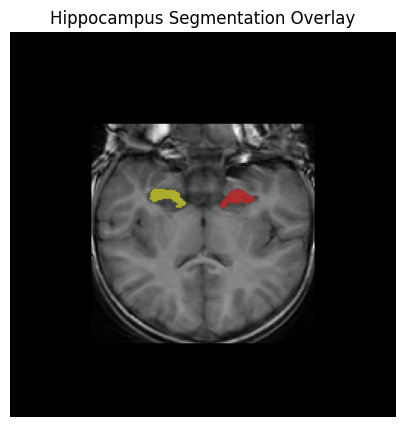

In [ ]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# Set file paths (update to match your dataset location)
image_path = "/content/drive/MyDrive/nnUNet_raw_data/Task107_Hippocampus/imagesTr/HC_021_0000.nii.gz"
label_path = "/content/drive/MyDrive/nnUNet_raw_data/Task107_Hippocampus/labelsTr/HC_021.nii.gz"

# Load image and label
image = nib.load(image_path).get_fdata()
label = nib.load(label_path).get_fdata()

# Choose a slice to visualize (e.g., middle slice along Z-axis)
slice_idx = image.shape[2] // 2
img_slice = image[:, :, slice_idx]
label_slice = label[:, :, slice_idx]

# Plot
plt.figure(figsize=(10, 5))
plt.imshow(img_slice.T, cmap="gray", origin="lower")
plt.imshow(np.ma.masked_where(label_slice == 0, label_slice).T, cmap="autumn", alpha=0.5, origin="lower")
plt.title("Hippocampus Segmentation Overlay")
plt.axis("off")
plt.show()


In [ ]:
print("Unique labels in segmentation:", np.unique(label.astype(int)))


Unique labels in segmentation: [0 1 2]


In [ ]:
import nibabel as nib
import numpy as np

# Load the label image
label_nii = nib.load(label_path)
label_data = label_nii.get_fdata()
label_data = label_data.astype(int)  # Ensure integer comparison

# Count number of voxels for each region
left_voxels = np.sum(label_data == 1)
right_voxels = np.sum(label_data == 2)

# Calculate volumes in mm³
left_volume = left_voxels
right_volume = right_voxels
total_volume = left_volume + right_volume

print(f"Left Hippocampus Volume:  {left_volume:.2f} mm³")
print(f"Right Hippocampus Volume: {right_volume:.2f} mm³")
print(f"Total Hippocampus Volume: {total_volume:.2f} mm³")


Left Hippocampus Volume:  2533.00 mm³
Right Hippocampus Volume: 2699.00 mm³
Total Hippocampus Volume: 5232.00 mm³


In [ ]:
!pip install nibabel matplotlib numpy

In [ ]:
!git clone https://github.com/MIC-DKFZ/nnUNet.git
%cd nnUNet
!pip install -e .

Cloning into 'nnUNet'...
remote: Enumerating objects: 13697, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 13697 (delta 7), reused 0 (delta 0), pack-reused 13684 (from 3)
Receiving objects: 100% (13697/13697), 8.04 MiB | 10.70 MiB/s, done.
Resolving deltas: 100% (10495/10495), done.
/content/nnUNet
Obtaining file:///content/nnUNet
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.

In [ ]:
import os

base_path = "/content/drive/MyDrive"
# Set environment variables
os.environ["nnUNet_raw"] = os.path.join(base_path, "nnUNet_raw_data")
os.environ["nnUNet_preprocessed"] = os.path.join(base_path, "nnUNet_preprocessed")
os.environ["nnUNet_results"] = os.path.join(base_path, "nnUNet_results")

# Create folders if they don't exist
os.makedirs(os.environ["nnUNet_raw"], exist_ok=True)
os.makedirs(os.environ["nnUNet_preprocessed"], exist_ok=True)
os.makedirs(os.environ["nnUNet_results"], exist_ok=True)

In [ ]:
from nnunetv2.paths import nnUNet_preprocessed, nnUNet_results, nnUNet_raw

print("Raw:", nnUNet_raw)
print("Preprocessed:", nnUNet_preprocessed)
print("Results:", nnUNet_results)

# # Define base directories
# raw_dataset_dir = "/content/drive/MyDrive/nnUNet_raw_data/Dataset103_Hippocampus"
# imagesTr_src = "/content/drive/MyDrive/Task04_Hippocampus/Task04_Hippocampus/imagesTr"
# labelsTr_src = "/content/drive/MyDrive/Task04_Hippocampus/Task04_Hippocampus/labelsTr"
# imagesTs_src = "/content/drive/MyDrive/Task04_Hippocampus/Task04_Hippocampus/imagesTs"

# # Create nnU-Net expected folders
# import os
# os.makedirs(f"{raw_dataset_dir}/imagesTr", exist_ok=True)
# os.makedirs(f"{raw_dataset_dir}/labelsTr", exist_ok=True)
# os.makedirs(f"{raw_dataset_dir}/imagesTs", exist_ok=True)

Raw: /content/drive/MyDrive/nnUNet_raw_data
Preprocessed: /content/drive/MyDrive/nnUNet_preprocessed
Results: /content/drive/MyDrive/nnUNet_results


In [ ]:
import SimpleITK as sitk
from pathlib import Path

def validate_and_fix_nii_gz(folder):
    for file in Path(folder).glob("*.nii.gz"):
        try:
            # Try to read with SimpleITK
            sitk.ReadImage(str(file))
        except Exception as e:
            print(f"❌ Corrupt file detected: {file.name}. Attempting to re-save with nibabel.")

            # Try fixing it using nibabel
            import nibabel as nib
            try:
                img = nib.load(str(file))
                nib.save(img, str(file))  # overwrite
                print(f"✅ Fixed: {file.name}")
            except Exception as ne:
                print(f"⚠️ Could not fix {file.name}: {ne}")

# Validate training and test images
validate_and_fix_nii_gz("/content/drive/MyDrive/nnUNet_raw_data/Task107_Hippocampus/imagesTr")
validate_and_fix_nii_gz("/content/drive/MyDrive/nnUNet_raw_data/Task107_Hippocampus/imagesTs")


In [ ]:
!nnUNetv2_convert_MSD_dataset \
  -i "/content/drive/MyDrive/nnUNet_raw_data/Task107_Hippocampus" -overwrite_id 104

In [ ]:
from pathlib import Path

imagesTr_dir = Path("/content/drive/MyDrive/nnUNet_raw_data/Dataset104_Hippocampus/imagesTr")

for file in imagesTr_dir.glob("*_0000_0000.nii.gz"):
    new_name = file.name.replace("_0000_0000.nii.gz", "_0000.nii.gz")
    file.rename(file.with_name(new_name))
    print(f"✅ Renamed: {file.name} → {new_name}")


✅ Renamed: BPDwPsy_065_0000_0000.nii.gz → BPDwPsy_065_0000.nii.gz
✅ Renamed: BPDwPsy_083_0000_0000.nii.gz → BPDwPsy_083_0000.nii.gz
✅ Renamed: BPDwPsy_073_0000_0000.nii.gz → BPDwPsy_073_0000.nii.gz
✅ Renamed: BPDwPsy_077_0000_0000.nii.gz → BPDwPsy_077_0000.nii.gz
✅ Renamed: BPDwoPsy_038_0000_0000.nii.gz → BPDwoPsy_038_0000.nii.gz
✅ Renamed: BPDwPsy_080_0000_0000.nii.gz → BPDwPsy_080_0000.nii.gz
✅ Renamed: BPDwPsy_070_0000_0000.nii.gz → BPDwPsy_070_0000.nii.gz
✅ Renamed: BPDwoPsy_033_0000_0000.nii.gz → BPDwoPsy_033_0000.nii.gz
✅ Renamed: BPDwoPsy_030_0000_0000.nii.gz → BPDwoPsy_030_0000.nii.gz
✅ Renamed: BPDwPsy_074_0000_0000.nii.gz → BPDwPsy_074_0000.nii.gz
✅ Renamed: BPDwPsy_078_0000_0000.nii.gz → BPDwPsy_078_0000.nii.gz
✅ Renamed: BPDwPsy_067_0000_0000.nii.gz → BPDwPsy_067_0000.nii.gz
✅ Renamed: BPDwoPsy_039_0000_0000.nii.gz → BPDwoPsy_039_0000.nii.gz
✅ Renamed: BPDwoPsy_034_0000_0000.nii.gz → BPDwoPsy_034_0000.nii.gz
✅ Renamed: BPDwPsy_071_0000_0000.nii.gz → BPDwPsy_071_0000.nii.gz


In [ ]:
from pathlib import Path

imagesTr_dir = Path("/content/drive/MyDrive/nnUNet_raw_data/Dataset104_Hippocampus/imagesTs")

for file in imagesTr_dir.glob("*_0000_0000.nii.gz"):
    new_name = file.name.replace("_0000_0000.nii.gz", "_0000.nii.gz")
    file.rename(file.with_name(new_name))
    print(f"✅ Renamed: {file.name} → {new_name}")


✅ Renamed: BPDwPsy_066_0000_0000.nii.gz → BPDwPsy_066_0000.nii.gz
✅ Renamed: BPDwPsy_069_0000_0000.nii.gz → BPDwPsy_069_0000.nii.gz
✅ Renamed: BPDwPsy_075_0000_0000.nii.gz → BPDwPsy_075_0000.nii.gz
✅ Renamed: BPDwoPsy_031_0000_0000.nii.gz → BPDwoPsy_031_0000.nii.gz
✅ Renamed: BPDwoPsy_042_0000_0000.nii.gz → BPDwoPsy_042_0000.nii.gz
✅ Renamed: BPDwoPsy_035_0000_0000.nii.gz → BPDwoPsy_035_0000.nii.gz
✅ Renamed: BPDwoPsy_036_0000_0000.nii.gz → BPDwoPsy_036_0000.nii.gz
✅ Renamed: BPDwoPsy_048_0000_0000.nii.gz → BPDwoPsy_048_0000.nii.gz
✅ Renamed: BPDwoPsy_060_0000_0000.nii.gz → BPDwoPsy_060_0000.nii.gz
✅ Renamed: BPDwoPsy_050_0000_0000.nii.gz → BPDwoPsy_050_0000.nii.gz
✅ Renamed: HC_012_0000_0000.nii.gz → HC_012_0000.nii.gz
✅ Renamed: HC_013_0000_0000.nii.gz → HC_013_0000.nii.gz
✅ Renamed: HC_022_0000_0000.nii.gz → HC_022_0000.nii.gz
✅ Renamed: HC_024_0000_0000.nii.gz → HC_024_0000.nii.gz
✅ Renamed: HC_029_0000_0000.nii.gz → HC_029_0000.nii.gz
✅ Renamed: SS_085_0000_0000.nii.gz → SS_085_00

In [ ]:
# Plan and preprocess
!nnUNetv2_plan_and_preprocess -d 104 --verify_dataset_integrity

Fingerprint extraction...
Dataset107_Hippocampus
Using <class 'nnunetv2.imageio.simpleitk_reader_writer.SimpleITKIO'> as reader/writer

####################
verify_dataset_integrity Done. 
If you didn't see any error messages then your dataset is most likely OK!
####################

Using <class 'nnunetv2.imageio.simpleitk_reader_writer.SimpleITKIO'> as reader/writer
100% 82/82 [01:16<00:00,  1.07it/s]
Experiment planning...

############################
INFO: You are using the old nnU-Net default planner. We have updated our recommendations. Please consider using those instead! Read more here: https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/resenc_presets.md
############################

Dropping 3d_lowres config because the image size difference to 3d_fullres is too small. 3d_fullres: [119. 147. 149.], 3d_lowres: [119, 147, 149]
2D U-Net configuration:
{'data_identifier': 'nnUNetPlans_2d', 'preprocessor_name': 'DefaultPreprocessor', 'batch_size': 127, 'patch_size': (np.

In [ ]:
# Plan and preprocess
!nnUNetv2_plan_and_preprocess -d 104 -c 3d_fullres --verbose

Fingerprint extraction...
Dataset104_Hippocampus
Using <class 'nnunetv2.imageio.simpleitk_reader_writer.SimpleITKIO'> as reader/writer
Experiment planning...

############################
INFO: You are using the old nnU-Net default planner. We have updated our recommendations. Please consider using those instead! Read more here: https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/resenc_presets.md
############################

Dropping 3d_lowres config because the image size difference to 3d_fullres is too small. 3d_fullres: [119. 147. 149.], 3d_lowres: [119, 147, 149]
2D U-Net configuration:
{'data_identifier': 'nnUNetPlans_2d', 'preprocessor_name': 'DefaultPreprocessor', 'batch_size': 127, 'patch_size': (np.int64(160), np.int64(160)), 'median_image_size_in_voxels': array([147., 149.]), 'spacing': array([0.9375, 0.9375]), 'normalization_schemes': ['ZScoreNormalization'], 'use_mask_for_norm': [True], 'resampling_fn_data': 'resample_data_or_seg_to_shape', 'resampling_fn_seg': '

In [ ]:
!nnUNetv2_train 104 3d_fullres 1


############################
INFO: You are using the old nnU-Net default plans. We have updated our recommendations. Please consider using those instead! Read more here: https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/resenc_presets.md
############################

Using device: cuda:0

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

2025-05-07 00:57:56.503550: Using torch.compile...
2025-05-07 00:57:59.547010: do_dummy_2d_data_aug: False
2025-05-07 00:57:59.557049: Creating new 5-fold cross-validation split...
2025-05-07 00:57:59.568160: Desired fold for training: 1
2025-05-07 00:57:59.572640: This split has 65 training and

In [ ]:
!nnUNetv2_find_best_configuration 104 -c 3d_fullres -f 1


***All results:***
nnUNetTrainer__nnUNetPlans__3d_fullres: 0.3722588168318952

*Best*: nnUNetTrainer__nnUNetPlans__3d_fullres: 0.3722588168318952

***Determining postprocessing for best model/ensemble***
Removing all but the largest foreground region did not improve results!
Removing all but the largest component for 1 did not improve results! Dice before: 0.4246 after: 0.14275
Removing all but the largest component for 2 did not improve results! Dice before: 0.31992 after: 0.266

***Run inference like this:***

nnUNetv2_predict -d Dataset104_Hippocampus -i INPUT_FOLDER -o OUTPUT_FOLDER -f  1 -tr nnUNetTrainer -c 3d_fullres -p nnUNetPlans

***Once inference is completed, run postprocessing like this:***

nnUNetv2_apply_postprocessing -i OUTPUT_FOLDER -o OUTPUT_FOLDER_PP -pp_pkl_file /content/drive/MyDrive/nnUNet_results/Dataset104_Hippocampus/nnUNetTrainer__nnUNetPlans__3d_fullres/crossval_results_folds_1/postprocessing.pkl -np 8 -plans_json /content/drive/MyDrive/nnUNet_results/Datas

In [ ]:
!nnUNetv2_predict -d 104 -i "/content/drive/MyDrive/nnUNet_raw_data/Dataset104_Hippocampus/imagesTs" -o "/content/drive/MyDrive/nnUNet_raw_data/Dataset104_Hippocampus/Prediction" -f  1 -tr nnUNetTrainer -c 3d_fullres -p nnUNetPlans


#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

There are 21 cases in the source folder
I am process 0 out of 1 (max process ID is 0, we start counting with 0!)
There are 21 cases that I would like to predict

Predicting BPDwPsy_066:
perform_everything_on_device: True
100% 4/4 [00:05<00:00,  1.48s/it]
sending off prediction to background worker for resampling and export
done with BPDwPsy_066

Predicting BPDwPsy_069:
perform_everything_on_device: True
100% 4/4 [00:03<00:00,  1.29it/s]
sending off prediction to background worker for resampling and export
done with BPDwPsy_069

Predicting BPDwPsy_075:
perform_everything_on_device: True
100%

In [ ]:
!nnUNetv2_apply_postprocessing -i "/content/drive/MyDrive/nnUNet_raw_data/Dataset104_Hippocampus/Prediction" -o "/content/drive/MyDrive/nnUNet_raw_data/Dataset104_Hippocampus/PostProcessing" -pp_pkl_file /content/drive/MyDrive/nnUNet_results/Dataset104_Hippocampus/nnUNetTrainer__nnUNetPlans__3d_fullres/crossval_results_folds_1/postprocessing.pkl -np 8 -plans_json /content/drive/MyDrive/nnUNet_results/Dataset104_Hippocampus/nnUNetTrainer__nnUNetPlans__3d_fullres/crossval_results_folds_1/plans.json

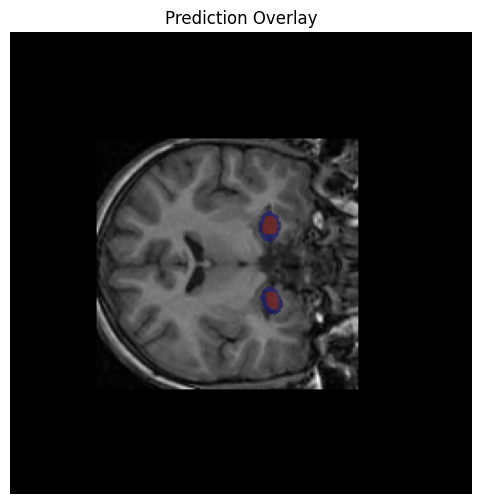

In [ ]:
import nibabel as nib, matplotlib.pyplot as plt, numpy as np

# Load an example image and prediction
img = nib.load("/content/drive/MyDrive/nnUNet_raw_data/Dataset104_Hippocampus/imagesTs/BPDwPsy_066_0000.nii.gz").get_fdata()
pred = nib.load("/content/drive/MyDrive/nnUNet_raw_data/Dataset104_Hippocampus/PostProcessing/BPDwPsy_066.nii.gz").get_fdata()

# Visualize the center axial slice
slice_idx = img.shape[2] // 2
plt.figure(figsize=(8, 6))
plt.imshow(img[:, :, slice_idx], cmap="gray")
plt.imshow(np.ma.masked_where(pred[:, :, slice_idx] == 0, pred[:, :, slice_idx]), cmap="jet", alpha=0.5)
plt.title("Prediction Overlay")
plt.axis("off")
plt.show()


In [ ]:
np.unique(pred)

array([0., 1., 2.])

In [ ]:
# Count number of voxels for each region
left_voxels = np.sum(pred == 1)
right_voxels = np.sum(pred == 2)

# Calculate volumes in mm³
left_volume = left_voxels
right_volume = right_voxels
total_volume = left_volume + right_volume

print(f"Left Hippocampus Volume:  {left_volume:.2f} mm³")
print(f"Right Hippocampus Volume: {right_volume:.2f} mm³")
print(f"Total Hippocampus Volume: {total_volume:.2f} mm³")

Left Hippocampus Volume:  2883.00 mm³
Right Hippocampus Volume: 1501.00 mm³
Total Hippocampus Volume: 4384.00 mm³


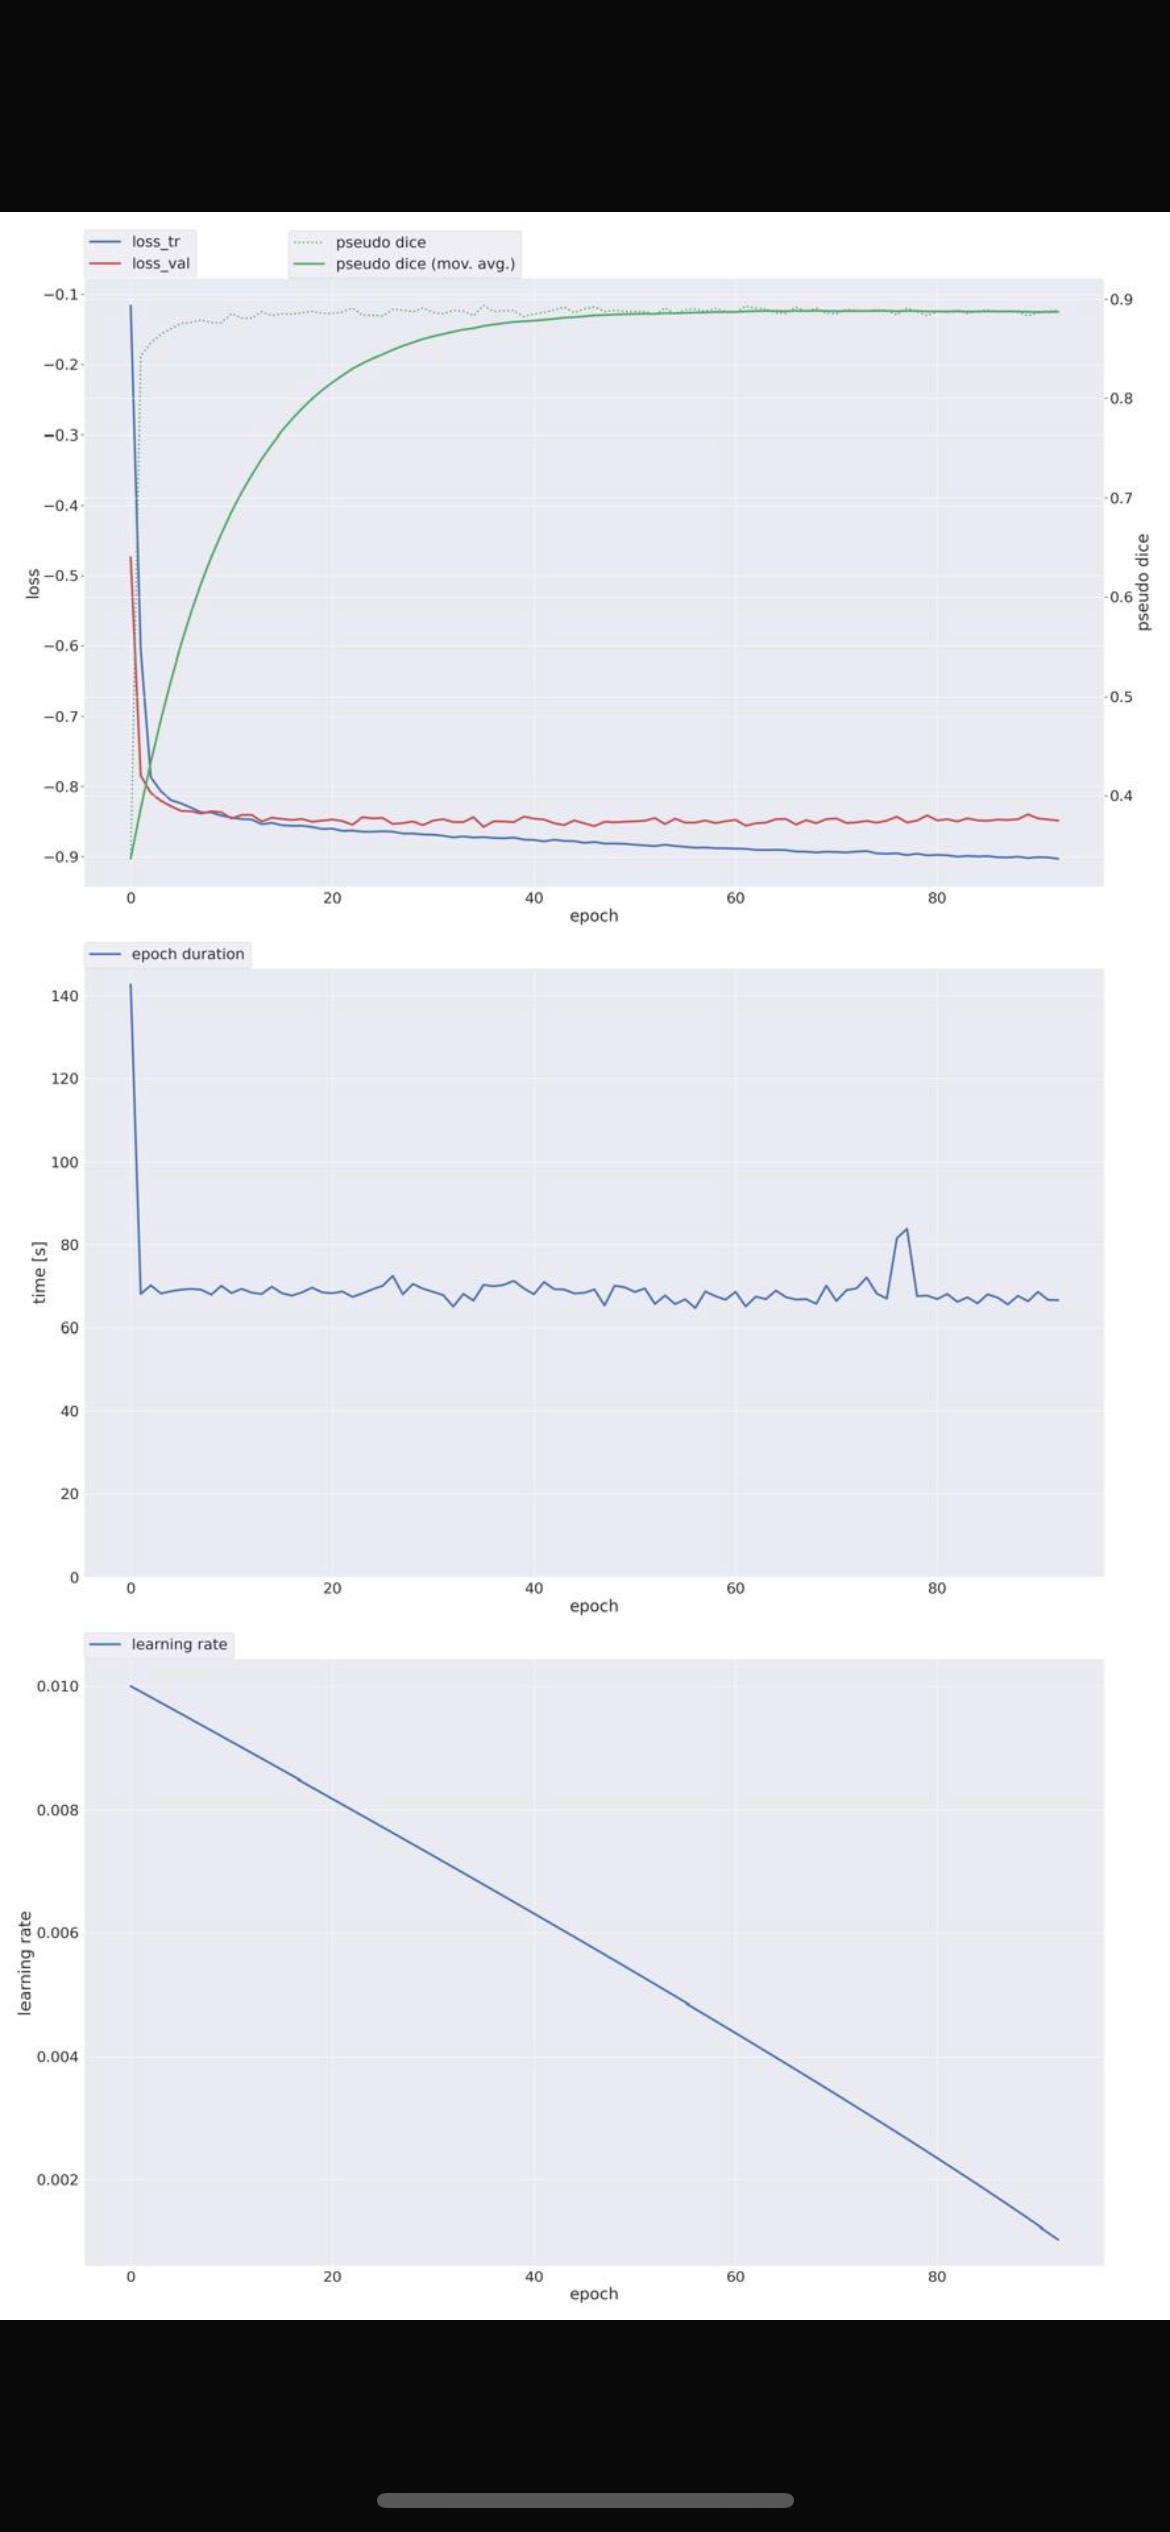

In [ ]:
!nnUNetv2_evaluate_folder -h

usage: nnUNetv2_evaluate_folder [-h] -djfile DJFILE -pfile PFILE [-o O]
                                [-np NP] [--chill]
                                gt_folder pred_folder

positional arguments:
  gt_folder       folder with gt segmentations
  pred_folder     folder with predicted segmentations

options:
  -h, --help      show this help message and exit
  -djfile DJFILE  dataset.json file
  -pfile PFILE    plans.json file
  -o O            Output file. Optional. Default: pred_folder/summary.json
  -np NP          number of processes used. Optional. Default: 8
  --chill         dont crash if folder_pred does not have all files that are
                  present in folder_gt


In [ ]:
# Re-import necessary modules after code state reset
import os
import numpy as np
import pandas as pd
import nibabel as nib
# import acetools as tools

# Define paths again
prediction_dir = "/content/drive/MyDrive/nnUNet_raw_data/Dataset104_Hippocampus/PostProcessing"
train = "/content/drive/MyDrive/nnUNet_raw_data/Dataset104_Hippocampus/labelsTr"
voxel_volume_mm3 = 1.0  # Assuming isotropic voxels

# Volume calculation utility
def compute_volumes(mask):
    left = (mask == 1).sum() * voxel_volume_mm3
    right = (mask == 2).sum() * voxel_volume_mm3
    return left, right, left + right

# Loop over all predicted masks
volume_stats = []
train_vol = []
for fname in sorted(os.listdir(prediction_dir)):
    if not fname.endswith(".nii.gz"):
        continue
    path = os.path.join(prediction_dir, fname)
    mask = nib.load(path).get_fdata()
    left_vol, right_vol, total_vol = compute_volumes(mask)
    volume_stats.append((fname, left_vol, right_vol, total_vol))

for fname in sorted(os.listdir(train)):
    if not fname.endswith(".nii.gz"):
        continue
    path = os.path.join(train, fname)
    mask = nib.load(path).get_fdata()
    left_vol, right_vol, total_vol = compute_volumes(mask)
    train_vol.append((fname, left_vol, right_vol, total_vol))


# Create DataFrame
df_volumes = pd.DataFrame(volume_stats, columns=["filename", "anterior_volume", "posterior_volume", "total_volume"])
df_train = pd.DataFrame(train_vol, columns=["filename", "anterior_volume", "posterior_volume", "total_volume"])
# Outlier detection using 5th percentile
total_mean = df_volumes["total_volume"].mean()
total_std = df_volumes["total_volume"].std()
total_5th = np.percentile(df_volumes["total_volume"], 5)

df_volumes["is_low_volume_outlier"] = df_volumes["total_volume"] < 5000
df_train["is_low_volume_outlier"] = df_train["total_volume"] < 5000


{
    "mean_total_volume_mm3": round(total_mean, 2),
    "std_total_volume_mm3": round(total_std, 2),
    "5th_percentile_volume_mm3": round(total_5th, 2),
    "n_outliers": int(df_volumes["is_low_volume_outlier"].sum())
}

{'mean_total_volume_mm3': np.float64(5090.05),
 'std_total_volume_mm3': 561.31,
 '5th_percentile_volume_mm3': np.float64(4384.0),
 'n_outliers': 9}

In [ ]:
df_volumes

,filename,anterior_volume,posterior_volume,total_volume,is_low_volume_outlier
0,BPDwPsy_066.nii.gz,2883.0,1501.0,4384.0,True
1,BPDwPsy_069.nii.gz,2971.0,1437.0,4408.0,True
2,BPDwPsy_075.nii.gz,3315.0,1218.0,4533.0,True
3,BPDwoPsy_031.nii.gz,4079.0,632.0,4711.0,True
4,BPDwoPsy_035.nii.gz,3394.0,1317.0,4711.0,True
5,BPDwoPsy_036.nii.gz,3896.0,1224.0,5120.0,False
6,BPDwoPsy_042.nii.gz,3871.0,1460.0,5331.0,False
7,BPDwoPsy_048.nii.gz,3492.0,1712.0,5204.0,False
8,BPDwoPsy_050.nii.gz,3093.0,2193.0,5286.0,False
9,BPDwoPsy_060.nii.gz,2610.0,1477.0,4087.0,True


In [ ]:
df_train

,filename,anterior_volume,posterior_volume,total_volume,is_low_volume_outlier
0,BPDwPsy_065.nii.gz,2625.0,2486.0,5111.0,False
1,BPDwPsy_067.nii.gz,2786.0,2861.0,5647.0,False
2,BPDwPsy_068.nii.gz,2829.0,2828.0,5657.0,False
3,BPDwPsy_070.nii.gz,2630.0,2485.0,5115.0,False
4,BPDwPsy_071.nii.gz,2813.0,2851.0,5664.0,False
...,...,...,...,...,...
77,SS_099.nii.gz,3094.0,3276.0,6370.0,False
78,SS_100.nii.gz,2222.0,2215.0,4437.0,True
79,SS_101.nii.gz,2171.0,2538.0,4709.0,True
80,SS_102.nii.gz,2554.0,2611.0,5165.0,False


In [ ]:
import os
import numpy as np
import pandas as pd
import nibabel as nib

prediction_dir = "/content/drive/MyDrive/nnUNet_raw_data/Dataset104_Hippocampus/PostProcessing"
demographic = "/content/drive/MyDrive/Hippocampus/demographics/SchizBull_2008_Demographics_V1.1.csv"
voxel_volume_mm3 = 1.0  # Assuming isotropic voxel size

# Prepare SubjectID for matching
df_volumes["SubjectID"] = df_volumes["filename"].str.replace(".nii.gz","")
df_train["SubjectID"] = df_train["filename"].str.replace(".nii.gz","")
df_demo = pd.read_csv(demographic)

# Merge volume and demographic data
merged_df = pd.merge(df_volumes, df_demo, left_on="SubjectID", right_on = "Subject", how="left")
merged_train = pd.merge(df_train, df_demo, left_on="SubjectID", right_on = "Subject", how="left")

# Define thresholds
age_threshold = 10  # Young adult threshold
volume_threshold = df_volumes["total_volume"].quantile(0.05)  # 5th percentile cutoff

# Flag early brain aging risk
merged_df["early_aging_risk"] = (merged_df["total_volume"] < volume_threshold) & (merged_df["Age"] < age_threshold)

{
    "volume_threshold_mm3_5th_percentile": round(volume_threshold, 2),
    "young_age_threshold": age_threshold,
    "flagged_subjects_count": int(merged_df["early_aging_risk"].sum())
}

{'volume_threshold_mm3_5th_percentile': np.float64(4384.0),
 'young_age_threshold': 10,
 'flagged_subjects_count': 1}

In [ ]:
merged_df

,filename,anterior_volume,posterior_volume,total_volume,is_low_volume_outlier,SubjectID,Subject,Gender,Age,Handedness,Handed_extended,Weight (lbs),Height (in),Head_Circumference (cm),Tanner_Stage,early_aging_risk
0,BPDwPsy_066.nii.gz,2883.0,1501.0,4384.0,True,BPDwPsy_066,BPDwPsy_066,female,11.30,LH,mixed.LH,104,59,52.5,4,False
1,BPDwPsy_069.nii.gz,2971.0,1437.0,4408.0,True,BPDwPsy_069,BPDwPsy_069,female,16.50,RH,RH,144,69.75,56.2,5,False
2,BPDwPsy_075.nii.gz,3315.0,1218.0,4533.0,True,BPDwPsy_075,BPDwPsy_075,male,10.14,RH,RH,98,52.875,54,1,False
3,BPDwoPsy_031.nii.gz,4079.0,632.0,4711.0,True,BPDwoPsy_031,BPDwoPsy_031,female,15.60,RH,mixed.RH,188,61.5,57,5,False
4,BPDwoPsy_035.nii.gz,3394.0,1317.0,4711.0,True,BPDwoPsy_035,BPDwoPsy_035,male,8.60,RH,mixed.RH,83,50.5,53.5,1,False
5,BPDwoPsy_036.nii.gz,3896.0,1224.0,5120.0,False,BPDwoPsy_036,BPDwoPsy_036,male,8.80,RH,RH,95,53.75,54.5,1,False
6,BPDwoPsy_042.nii.gz,3871.0,1460.0,5331.0,False,BPDwoPsy_042,BPDwoPsy_042,male,13.60,RH,RH,95,66,56.2,1,False
7,BPDwoPsy_048.nii.gz,3492.0,1712.0,5204.0,False,BPDwoPsy_048,BPDwoPsy_048,female,15.30,RH,mixed.RH,120,61.5,54.2,5,False
8,BPDwoPsy_050.nii.gz,3093.0,2193.0,5286.0,False,BPDwoPsy_050,BPDwoPsy_050,male,8.90,RH,RH,52.5,52.5,53.5,1,False
9,BPDwoPsy_060.nii.gz,2610.0,1477.0,4087.0,True,BPDwoPsy_060,BPDwoPsy_060,female,5.30,RH,RH,53,45,52,1,True


In [ ]:
merged_train

,filename,anterior_volume,posterior_volume,total_volume,is_low_volume_outlier,SubjectID,Subject,Gender,Age,Handedness,Handed_extended,Weight (lbs),Height (in),Head_Circumference (cm),Tanner_Stage
0,BPDwPsy_065.nii.gz,2625.0,2486.0,5111.0,False,BPDwPsy_065,BPDwPsy_065,male,7.50,RH,RH,122,52,53,1
1,BPDwPsy_067.nii.gz,2786.0,2861.0,5647.0,False,BPDwPsy_067,BPDwPsy_067,male,8.90,RH,RH,107,57,55.8,1
2,BPDwPsy_068.nii.gz,2829.0,2828.0,5657.0,False,BPDwPsy_068,BPDwPsy_068,male,7.80,RH,mixed.RH,59,49,53.2,1
3,BPDwPsy_070.nii.gz,2630.0,2485.0,5115.0,False,BPDwPsy_070,BPDwPsy_070,male,13.90,RH,RH,181,64,55,4
4,BPDwPsy_071.nii.gz,2813.0,2851.0,5664.0,False,BPDwPsy_071,BPDwPsy_071,male,11.50,RH,RH,112,56.5,53.7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,SS_099.nii.gz,3094.0,3276.0,6370.0,False,SS_099,SS_099,female,16.19,RH,RH,120,62,53.8,5
78,SS_100.nii.gz,2222.0,2215.0,4437.0,True,SS_100,SS_100,female,8.42,RH,RH,95.5,50.5,53.34,2
79,SS_101.nii.gz,2171.0,2538.0,4709.0,True,SS_101,SS_101,male,11.75,RH,.,111,59,54.7,1
80,SS_102.nii.gz,2554.0,2611.0,5165.0,False,SS_102,SS_102,male,14.58,.,.,155,65.75,58,2


In [ ]:
test_data = merged_df[merged_df['is_low_volume_outlier'] == True][['total_volume','Age']]

In [ ]:
rem_data = pd.concat([merged_df[merged_df['is_low_volume_outlier'] == False], merged_train])

In [ ]:
rem_data = rem_data[['total_volume','Age']]

In [ ]:
rem_data

,total_volume,Age
5,5120.0,8.80
6,5331.0,13.60
7,5204.0,15.30
8,5286.0,8.90
11,5346.0,12.90
...,...,...
77,6370.0,16.19
78,4437.0,8.42
79,4709.0,11.75
80,5165.0,14.58


In [ ]:
rem_data['Age'] = rem_data['Age'].round()
rem_data

<ipython-input-30-ffd1a26305fa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rem_data['Age'] = rem_data['Age'].round()


,total_volume,Age
5,5120.0,9.0
6,5331.0,14.0
7,5204.0,15.0
8,5286.0,9.0
11,5346.0,13.0
...,...,...
77,6370.0,16.0
78,4437.0,8.0
79,4709.0,12.0
80,5165.0,15.0


In [ ]:
# Train a regression model to predict age based on volume
from sklearn.linear_model import LinearRegression

X = rem_data[["total_volume"]]
y = rem_data["Age"]

model = LinearRegression()
model.fit(X, y)

# Predict brain age
test_data["predicted_brain_age"] = model.predict(test_data[["total_volume"]])
test_data["brain_age_gap"] = test_data["predicted_brain_age"] - test_data["Age"]
test_data["accelerated_aging"] = test_data["brain_age_gap"] > 5

# # Display results
# from ace_tools import display_dataframe_to_user
# display_dataframe_to_user(name="Brain Age Estimation", dataframe=df)

# Also return model performance metrics
from sklearn.metrics import mean_absolute_error, r2_score

mae = mean_absolute_error(y, model.predict(X))
r2 = r2_score(y, model.predict(X))

mae, r2

(2.6189733468719383, 0.004694235650387957)

In [ ]:
test_data

,total_volume,Age,predicted_brain_age,brain_age_gap,accelerated_aging
0,4384.0,11.30,10.785221,-0.514779,False
1,4408.0,16.50,10.793490,-5.706510,False
2,4533.0,10.14,10.836561,0.696561,False
3,4711.0,15.60,10.897893,-4.702107,False
4,4711.0,8.60,10.897893,2.297893,False
9,4087.0,5.30,10.682885,5.382885,True
10,4991.0,11.90,10.994371,-0.905629,False
15,4535.0,14.30,10.837250,-3.462750,False
20,4704.0,11.30,10.895481,-0.404519,False


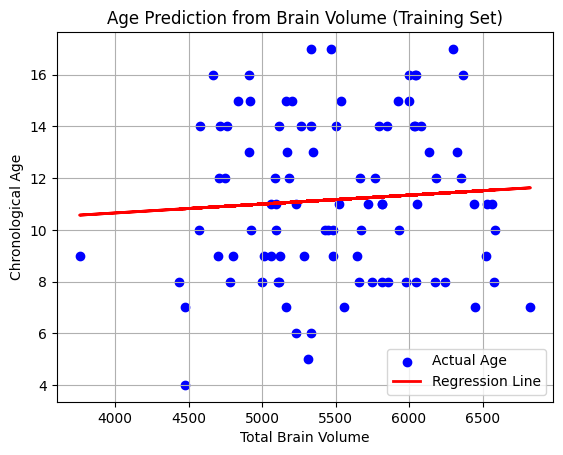

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract X and y
X = rem_data[["total_volume"]]
y = rem_data["Age"]

# Predict y using trained model
y_pred = model.predict(X)

# Plot original data
plt.scatter(X, y, color='blue', label='Actual Age')

# Plot regression line
plt.plot(X, y_pred, color='red', linewidth=2, label='Regression Line')

plt.xlabel("Total Brain Volume")
plt.ylabel("Chronological Age")
plt.title("Age Prediction from Brain Volume (Training Set)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
def assign_brain_age(volume):
    if volume >= 5300:
        return 25
    elif volume >= 5000:
        return 35
    elif volume >= 4700:
        return 45
    elif volume >= 4400:
        return 55
    elif volume >= 4100:
        return 65
    elif volume >= 3800:
        return 75
    elif volume >= 3500:
        return 85
    else:
        return 90  # very atrophied

In [ ]:
merged_df["predicted_brain_age"] = merged_df["total_volume"].apply(assign_brain_age)
merged_df["brain_age_gap"] = merged_df["predicted_brain_age"] - merged_df["Age"]
merged_df["accelerated_aging"] = merged_df["brain_age_gap"] > 5

In [ ]:
merged_df

,filename,anterior_volume,posterior_volume,total_volume,is_low_volume_outlier,SubjectID,Subject,Gender,Age,Handedness,Handed_extended,Weight (lbs),Height (in),Head_Circumference (cm),Tanner_Stage,early_aging_risk,predicted_brain_age,brain_age_gap,accelerated_aging
0,BPDwPsy_066.nii.gz,2883.0,1501.0,4384.0,True,BPDwPsy_066,BPDwPsy_066,female,11.30,LH,mixed.LH,104,59,52.5,4,False,65,53.70,True
1,BPDwPsy_069.nii.gz,2971.0,1437.0,4408.0,True,BPDwPsy_069,BPDwPsy_069,female,16.50,RH,RH,144,69.75,56.2,5,False,55,38.50,True
2,BPDwPsy_075.nii.gz,3315.0,1218.0,4533.0,True,BPDwPsy_075,BPDwPsy_075,male,10.14,RH,RH,98,52.875,54,1,False,55,44.86,True
3,BPDwoPsy_031.nii.gz,4079.0,632.0,4711.0,True,BPDwoPsy_031,BPDwoPsy_031,female,15.60,RH,mixed.RH,188,61.5,57,5,False,45,29.40,True
4,BPDwoPsy_035.nii.gz,3394.0,1317.0,4711.0,True,BPDwoPsy_035,BPDwoPsy_035,male,8.60,RH,mixed.RH,83,50.5,53.5,1,False,45,36.40,True
5,BPDwoPsy_036.nii.gz,3896.0,1224.0,5120.0,False,BPDwoPsy_036,BPDwoPsy_036,male,8.80,RH,RH,95,53.75,54.5,1,False,35,26.20,True
6,BPDwoPsy_042.nii.gz,3871.0,1460.0,5331.0,False,BPDwoPsy_042,BPDwoPsy_042,male,13.60,RH,RH,95,66,56.2,1,False,25,11.40,True
7,BPDwoPsy_048.nii.gz,3492.0,1712.0,5204.0,False,BPDwoPsy_048,BPDwoPsy_048,female,15.30,RH,mixed.RH,120,61.5,54.2,5,False,35,19.70,True
8,BPDwoPsy_050.nii.gz,3093.0,2193.0,5286.0,False,BPDwoPsy_050,BPDwoPsy_050,male,8.90,RH,RH,52.5,52.5,53.5,1,False,35,26.10,True
9,BPDwoPsy_060.nii.gz,2610.0,1477.0,4087.0,True,BPDwoPsy_060,BPDwoPsy_060,female,5.30,RH,RH,53,45,52,1,True,75,69.70,True
